In [1]:
import numpy as np
from itertools import product
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib inline
%matplotlib notebook

In [2]:
### Select domain
domain_start = 0
domain_end = 1
domain = np.linspace(domain_start, domain_end, 500)

# Sparse Grid Interpolation Toolbox Functions

In [3]:
###################################################################
# Basis and Coefficient Routines
###################################################################
def build_hat(level, node, domain):
    mesh_delta = 1./(2**(level))
    hat_function = np.zeros(len(domain))
    hat_function = 1. - np.abs(domain/mesh_delta - node)
    hat_function = np.clip(hat_function,0,None)  
    return hat_function

def find_coeff_1D(level, node, func):
    mesh_delta = 1/(2**(level))
    point1 = func(node*mesh_delta)
    point2 = func((node-1)*mesh_delta)
    point3 = func((node+1)*mesh_delta)
    
    return point1 - (point2 + point3)/2.0

def find_coe_2D(level1, level2, node1, node2, func):
    mesh_size1 = 1/(2**(level1))
    mesh_size2 = 1/(2**(level2))
    
    point = np.zeros(9)
    point[0] = func((node1)*mesh_size1,(node2)*mesh_size2)
    point[1] = func((node1-1)*mesh_size1,(node2)*mesh_size2) 
    point[2] = func((node1+1)*mesh_size1,(node2)*mesh_size2) 
    point[3] = func((node1)*mesh_size1,(node2-1)*mesh_size2) 
    point[4] = func((node1-1)*mesh_size1,(node2-1)*mesh_size2) 
    point[5] = func((node1+1)*mesh_size1,(node2-1)*mesh_size2) 
    point[6] = func((node1)*mesh_size1,(node2+1)*mesh_size2) 
    point[7] = func((node1-1)*mesh_size1,(node2+1)*mesh_size2) 
    point[8] = func((node1+1)*mesh_size1,(node2+1)*mesh_size2)
    
    coe = point[0]  
    coe = coe - (point[1]+point[2]+point[3]+point[6])/2
    coe = coe + (point[5]+point[4]+point[7]+point[8])/4
    
    return coe

In [4]:
###################################################################
# 1- and 2-Dimensional Interpolation Routines
###################################################################
def interpolation_1D(max_level, domain, func, plot_basis_funcs=False):  
    level = np.arange(1,max_level+1,1)
    func_approx = [np.zeros(len(domain))]*(max_level+1)
    
    for lev in level:
        nodes = np.arange(1, 2**(lev), 2)
        for node in nodes:
            hat_hold = build_hat(lev,node,domain)
            coe_hold = find_coeff_1D(lev,node,func)
                
            func_approx[lev] = func_approx[lev] + coe_hold*hat_hold
            
    return func_approx

def add_level_1D(curr_approx,domain,func):
    curr_level = len(curr_approx)
    print(curr_level)
    
    curr_approx.append( np.zeros(len(domain)) )
    
    for lev in [curr_level]:
        nodes = np.arange(1, 2**(lev), 2)
        for node in nodes:
            hat_hold = build_hat(lev,node,domain)
            coe_hold = find_coeff_1D(lev,node,func)
            
            curr_approx[lev] = curr_approx[lev] + coe_hold*hat_hold
            
    return curr_approx

def interpolation_2D(max_level, domain, func, sparse = True):    
    level_single = np.arange(1,max_level+1,1)
    func_approx = [np.zeros((len(domain),len(domain)))]*(max_level+1)
    levels = list(product(level_single,level_single))
    if sparse:
        levels = [lev for lev in levels if np.sum(lev)<=max_level]
        
    for level in levels:
        ilev = np.max(level)
        nodes1 = np.arange(1,2**(level[0]),2)
        nodes2 = np.arange(1,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:           
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            func_approx[ilev] = func_approx[ilev] + coe_hold*hat_hold
            
    return func_approx

def add_level_2D(curr_approx, domain, func, sparse=True):
    curr_lev = len(curr_approx)
    print(curr_lev)
    
    level_single = np.arange(1,curr_lev+1,1)
    levels = list(product(level_single,level_single))
    if sparse:
        levels = [lev for lev in levels if np.sum(lev)==curr_lev+1]
    else:
        levels = [lev for lev in levels if np.max(lev)==curr_lev]
        
    curr_approx.append(np.zeros((len(domain),len(domain))))

    for level in levels:
        nodes1 = np.arange(1,2**(level[0]),2)
        nodes2 = np.arange(1,2**(level[1]),2)
        nodes = list(product(nodes1,nodes2))
        for node in nodes:
            hat_hold = np.outer(build_hat(level[0],node[0],domain),build_hat(level[1],node[1],domain))
            coe_hold = find_coe_2D(level[0],level[1],node[0],node[1],func)
            curr_approx[-1] = curr_approx[-1] + coe_hold*hat_hold
            
    return curr_approx

# Test Cases

In [5]:
###################################################################
### Sample test functions for interpolation in 1- and 2-D
###################################################################

### currently must vanish at end points/boundary

# 1-dimensional
def sine( x_val ):
    return np.sin(np.pi*x_val)

def cosine( x_val ):
    return 0.5-0.5*np.cos(2*np.pi*x_val)

def gaussian( x_val ):
    return np.exp(-(x_val-0.5)**2/0.05)

def quadratic( x_val ):
    return -4.*(x_val-0.5)**2+1.0
    #return -(x_val-0.5)**2+0.25

def cubic( x_val ):
    return x_val*(x_val-0.5)*(x_val-1.0)

def quartic( x_val ):
    return -20*x_val*(x_val-0.3)*(x_val-0.6)*(x_val-1.)

def incfrq( x_val ):
    return x_val*(1-x_val)*np.sin(1./(x_val+0.0001))

def flat_exp( x_val ):
    return np.exp(-(x_val-0.5)**6/0.001)

# 2-dimensional
def gaussian_2D(x_val, y_val):
    return np.exp(-((x_val-0.5)**2+(y_val-0.5)**2)/0.05)
    
def quadratic_2D(x_val, y_val):
    return x_val*(x_val-1)*y_val*(y_val-1)

def cubic_2D(x_val, y_val):
    return x_val*(x_val-1)*(x_val-0.5)*y_val*(y_val-1)*(y_val-0.5)

def sine_2D(x_val, y_val):
    return np.sin(x_val*np.pi)*np.sin(y_val*np.pi)

def incfrq_2D(x_val, y_val):
    return x_val*(1-x_val)*np.sin(1./(x_val+0.0001))*y_val*(1-y_val)*np.sin(1./(y_val+0.0001))


In [13]:
def plot_1D_case(domain,func,nlevs):
    fig, ax = plt.subplots(1,1,figsize=(6,6))

    yinterp = interpolation_1D(nlevs,domain,func,plot_basis_funcs=True)

    ax.plot(domain,sum(yinterp),label='Interpolation')
    ax.plot(domain,func(domain),label='Original Function')


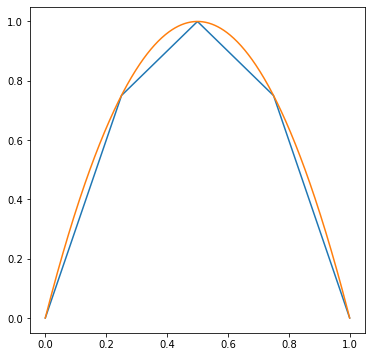

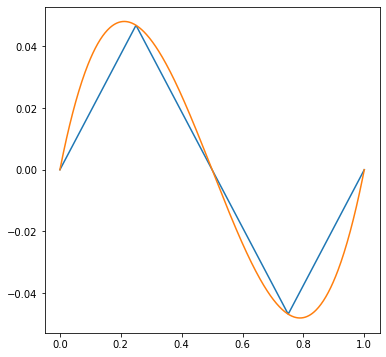

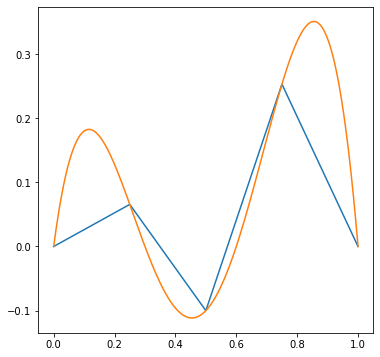

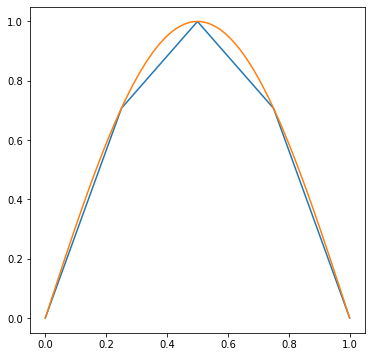

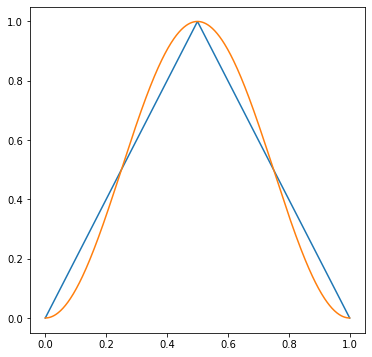

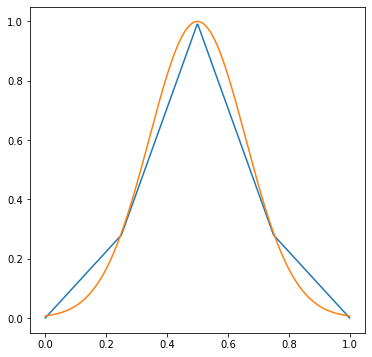

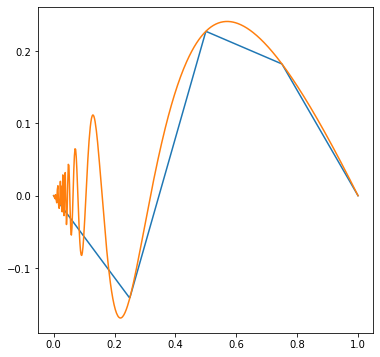

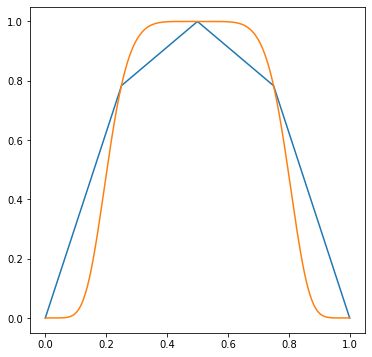

In [16]:
nlevs = 2
plot_1D_case(domain,quadratic,nlevs)
plot_1D_case(domain,cubic,nlevs)
plot_1D_case(domain,quartic,nlevs)
plot_1D_case(domain,sine,nlevs)
plot_1D_case(domain,cosine,nlevs)
plot_1D_case(domain,gaussian,nlevs)
plot_1D_case(domain,incfrq,nlevs)
plot_1D_case(domain,flat_exp,nlevs)

In [8]:
zsparse = interpolation_2D(8,domain,quadratic_2D,sparse=False)
zdense  = interpolation_2D(8,domain,quadratic_2D,sparse=True)

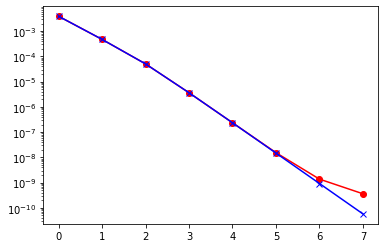

In [12]:
X,Y = np.meshgrid(domain,domain)
# plt.contour(X,Y,quadratic_2D(X,Y),cmap=plt.cm.Greys)
# plt.contour(X,Y,sum(zdense),cmap=plt.cm.Reds)
# plt.contour(X,Y,sum(zsparse),cmap=plt.cm.Blues)

L2err_dense = []
L2err_sparse = []
for i in range(1,len(zdense)):
    #plt.figure()
    #plt.contourf(X,Y,err2,cmap=plt.cm.Reds)
    #plt.colorbar()
    
    err2 = (sum(zdense[:i])-quadratic_2D(X,Y))**2
    L2err_dense.append(np.max(np.max(err2)))
    err2 = (sum(zsparse[:i])-quadratic_2D(X,Y))**2
    L2err_sparse.append(np.max(np.max(err2)))
    
    
# plt.figure()
# plt.contourf(X,Y,np.abs(sum(zsparse)-quadratic_2D(X,Y)),cmap=plt.cm.Blues)
# #plt.contour(X,Y,errsparse[-1],cmap=plt.cm.Blues)

plt.figure()
plt.semilogy(L2err_dense,color='r',marker='o')
plt.semilogy(L2err_sparse,color='b',marker='x')

In [ ]:
X,Y = np.meshgrid(domain,domain)
fig = plt.figure(figsize=(16.,6.));
ax  = fig.add_subplot(1,1,1, projection='3d');
ax.plot_surface(X,Y,incfrq_2D(X,Y))